# Project Understanding

The purpose of this project is to automate the loan eligibility process based on customer detail provided while filling out the online application form. Those details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. And in this project we will use ANN and KNN for classify if the applicant loan approve or not.

#### Source Data
Link : https://www.kaggle.com/datasets/rishikeshkonapure/home-loan-approval?select=loan_sanction_train.csv

#### Data Dictionary
- Loan_ID - Applicant Identifier 
- Gender - Female / Male
- Married - Y (yes) / N (no)
- Dependents - Number of dependents- Education - Applicant Education (Graduate / Not)
- Self_Employed - Y (yes) / N (no)
- ApplicantIncome - Applicant Income ($)
- CoapplicantIncome - Co applicant Income ($)
- LoanAmount - Loan Amount (thousand $)
- Loan_Amount_Term - Term of the loan (months)
- Credit_History - credit history meets guidelines
- Property_Area - Urban / Semi Urban / Rural
- Loan_Status (Target) - Loan Approval Y / N



# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, kruskal, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import  GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

# Load Data

In [2]:
df = pd.read_csv('loan_sanction_train.csv')

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

# Data Pre Processing

In [6]:
df = df.drop(columns=['Loan_ID'])

In [7]:
df['Gender'].value_counts()

Gender
Male      489
Female    112
Name: count, dtype: int64

In [8]:
df['Gender'].mode()

0    Male
Name: Gender, dtype: object

In [9]:
df['Gender'] = df['Gender'].fillna('Male')

In [10]:
df['Married'].value_counts()

Married
Yes    398
No     213
Name: count, dtype: int64

In [11]:
df['Married'] = df['Married'].fillna('unknown')

In [12]:
df['Dependents'].value_counts()

Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64

In [13]:
df['Dependents'] = df['Dependents'].fillna('unknown')

In [14]:
df['Self_Employed'].mode()

0    No
Name: Self_Employed, dtype: object

In [15]:
df['Self_Employed'] = df['Self_Employed'].fillna('No')

In [16]:
df = df.dropna(subset=['LoanAmount', 'Loan_Amount_Term', 'Credit_History'])

In [17]:
df['Credit_History'].value_counts()

Credit_History
1.0    450
0.0     79
Name: count, dtype: int64

In [18]:
credit_history = []
for i in df['Credit_History']:
    if i == 1.0:
        credit_history.append('Yes')
    elif i == 0.0:
        credit_history.append('No')
    else:
        credit_history.append('unknown')

In [19]:
df['Credit_History'] = credit_history

In [20]:
df.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# EDA

In [21]:
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')

## Label Distribution

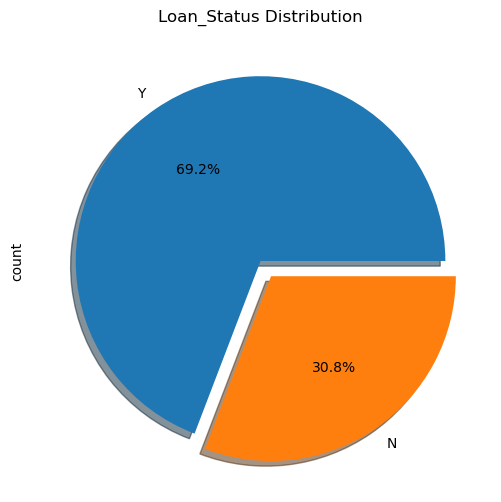

In [22]:
df['Loan_Status'].value_counts().plot.pie(
    autopct='%1.1f%%',
    explode=(0, 0.1),
    figsize=(6, 6),    
    shadow=True,
    title='Loan_Status Distribution' 
)
plt.show()

Based on the above plot, it shows that the majority of loan statuses are approved (Y) with 69.2% compare with not approved (N) with 30.8%.

## Numerical Features Analysis

In [23]:
df_num['Loan_Status'] = df['Loan_Status']

In [24]:
def histplot_and_boxplot(df_num, column, hue):
    
    fig, axes = plt.subplots(1,4, figsize=(20, 4))

    sns.histplot(data=df_num, x=column, ax=axes[0])
    axes[0].set_title(f'{column} Distribution')
    q1 = df_num[column].quantile(0.25)
    q3 = df_num[column].quantile(0.75)
    axes[0].axvline(q1, color='red', linestyle='--')
    axes[0].axvline(q3, color='blue', linestyle='--')
    ymax= axes[0].get_ylim()[1]
    xmax = axes[0].get_xlim()[1]
    axes[0].text(x=q1-(q1*0.05), y=ymax-ymax*0.1, s='Q1', color='red', 
                 va='bottom', ha='right', fontsize=9)
    axes[0].text(x=q3+(q3*0.05), y=ymax-ymax*0.1, s='Q3', color='blue', 
                 va='bottom', ha='left', fontsize=9)
    axes[0].text(x=xmax-xmax*0.35, y=ymax*0.5, s=f'Q1 & Q3\nQ1 = {q1}\nQ3 = {q3}', color='red', 
                 va='bottom', ha='left', fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='red', boxstyle='round,pad=0.3'))    
    
    sns.histplot(data=df_num, x=column, hue=hue, multiple="stack", stat="count", discrete=False, ax=axes[1])
    axes[1].set_title(f'{column} Distribution')
    q1_loan_y = df_num[df_num[hue] == 'Y'][column].quantile(0.25)
    q3_loan_y = df_num[df_num[hue] == 'Y'][column].quantile(0.75)
    axes[1].axvline(q1_loan_y, color='purple', linestyle='--')
    axes[1].axvline(q3_loan_y, color='blue', linestyle='--')
    ymax_loan_y= axes[1].get_ylim()[1]
    xmax_loan_y = axes[1].get_xlim()[1]
    axes[1].text(x=q1_loan_y-(q1_loan_y*0.05), y=ymax_loan_y-ymax_loan_y*0.1, s='Q1', color='purple', 
                 va='bottom', ha='right', fontsize=9)
    axes[1].text(x=q3_loan_y+(q3_loan_y*0.05), y=ymax_loan_y-ymax_loan_y*0.1, s='Q3', color='blue', 
                 va='bottom', ha='left', fontsize=9)
    axes[1].text(x=xmax_loan_y-xmax_loan_y*0.35, y=ymax_loan_y*0.5, s=f'Q1 & Q3 Loan = y\nQ1 = {q1_loan_y}\nQ3 = {q3_loan_y}', color='red', 
                 va='bottom', ha='left', fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='red', boxstyle='round,pad=0.3'))

    sns.boxplot(data=df_num, y=column, width=0.4, ax=axes[2])
    axes[2].set_title(f'{column} Distribution')
    axes[2].axhline(q1, color='red', linestyle='--', label='Q1')
    axes[2].axhline(q3, color='blue', linestyle='--', label='Q3')
    axes[2].text(x=-0.4, y=q1-q1*0.1, s=f'Q1 = {q1:.2f}', color='red', 
                 va='top', ha='left', fontsize=9)
    axes[2].text(x=-0.4, y=q3+q3*0.1, s=f'Q3 = {q3:.2f}', color='blue', 
                 va='bottom', ha='left', fontsize=9)
    axes[2].legend()
    
    sns.boxplot(data=df_num, y=column, hue=hue, gap=0.2, width=0.6, ax=axes[3])
    axes[3].set_title(f'{column} Distribution')

    plt.tight_layout()
    plt.show()

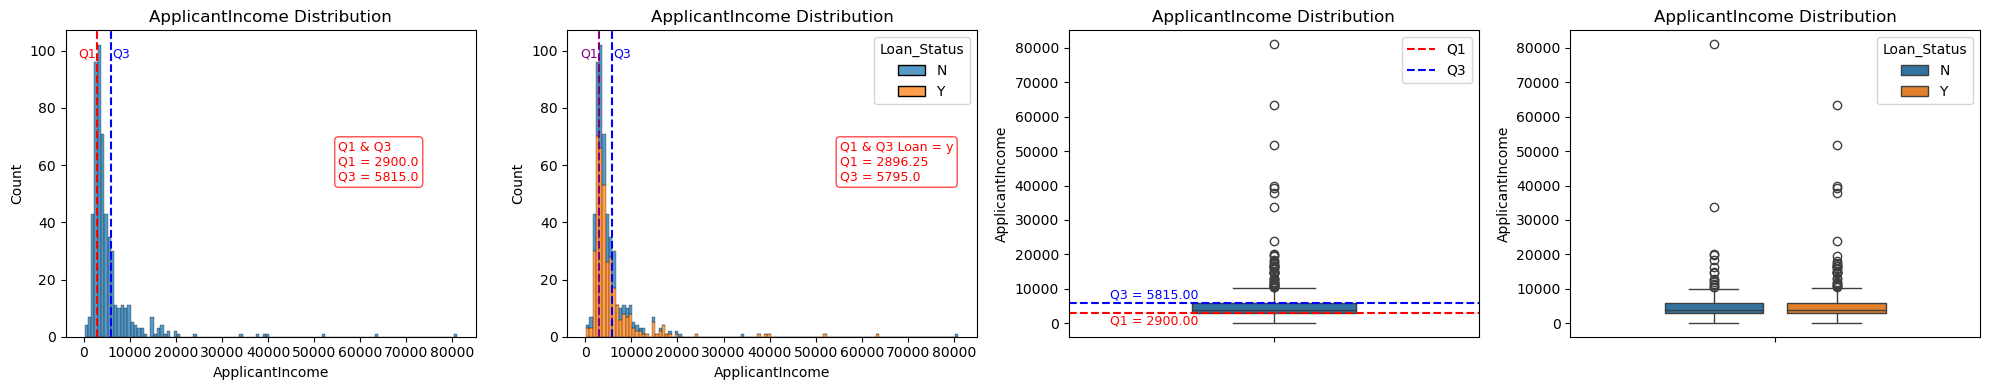

In [25]:
histplot_and_boxplot(df_num, 'ApplicantIncome', 'Loan_Status')

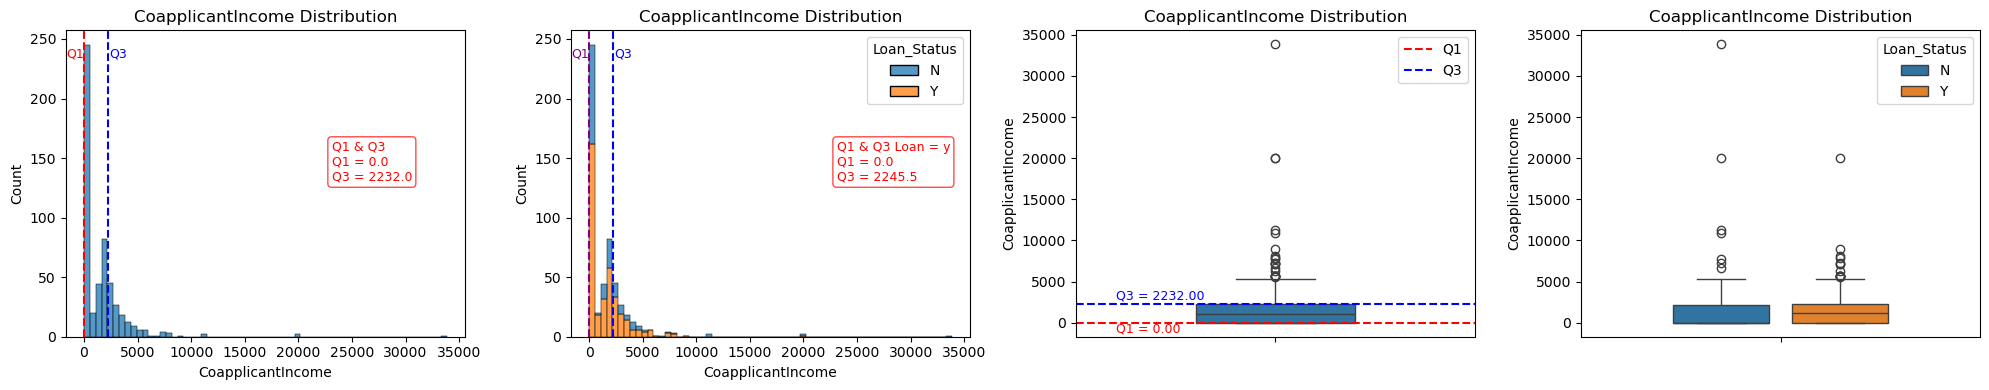

In [26]:
histplot_and_boxplot(df_num, 'CoapplicantIncome', 'Loan_Status')

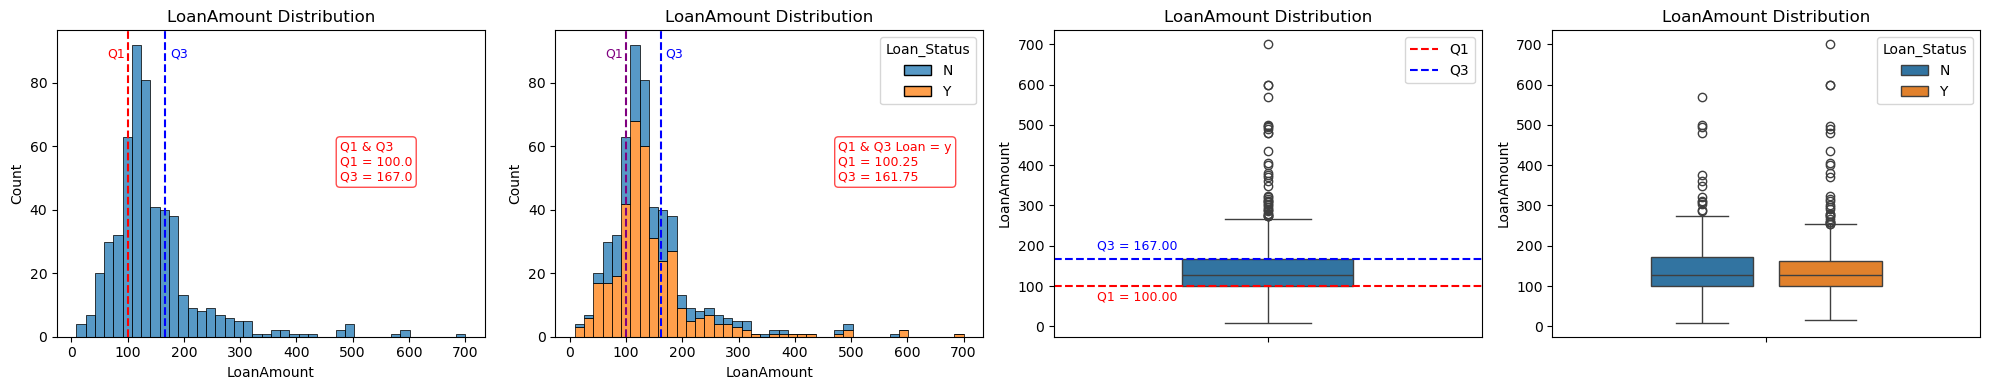

In [27]:
histplot_and_boxplot(df_num, 'LoanAmount', 'Loan_Status')

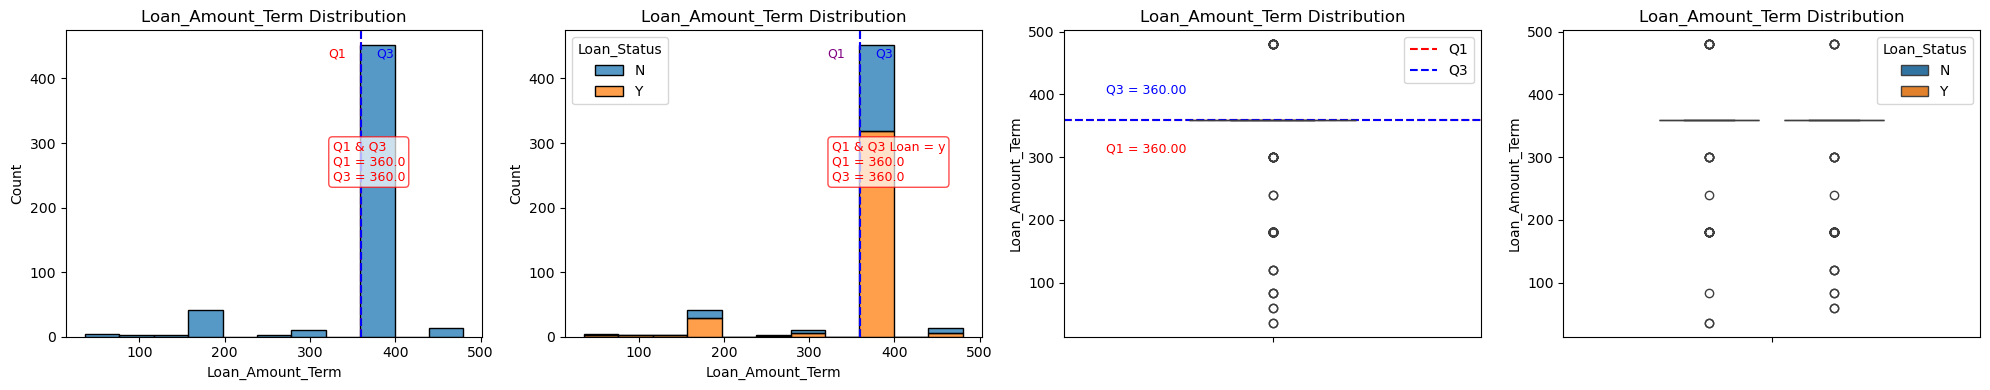

In [28]:
histplot_and_boxplot(df_num, 'Loan_Amount_Term', 'Loan_Status') 

1. ApplicantIncome
- The majority of ApplicantIncome is in the range (2900-5815), and for the approved loan status, they have ApplicantIncome in the range of 2896-5795.

2. CoapplicantIncome
- The majority of CoapplicantIncome is in the range (0-2232), and for the approved loan status, they have CoapplicantIncome in the range of 0-2245.

3. LoanAmount
- The majority of LoanAmount applicants is in the range (100-167), and for the approved loan status, they have a loan amount in the range of 100-161.

4. Loan_Amount_Term
- The majority of Loan_Amount_Term applicants is in the range (360-360), and for the approved loan status, they have a loan amount term in the range of 360-360.

5. All numerical features
- All the numerical features are not in normal distribution shape, so for correlation analysis we will use spearman method. And also all numerical features have outlier in observation so for scalling data we will use robust scaler to minimize the effects of outlier.

## Categorical Features Analysis

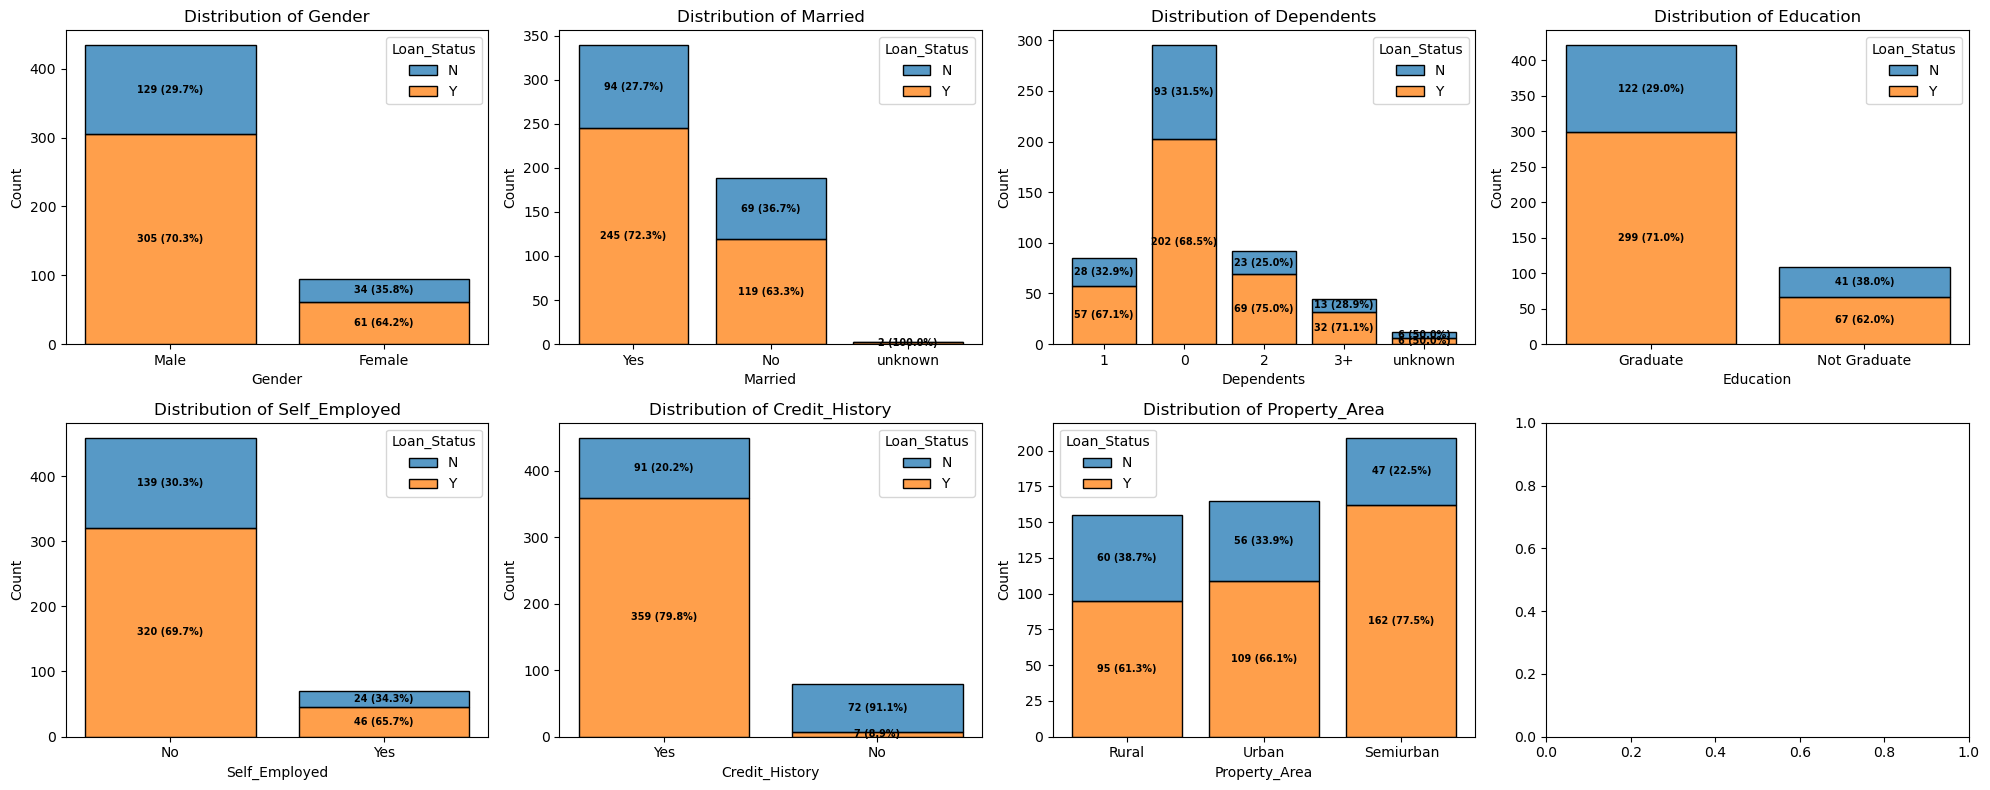

In [29]:
row = 0
col = 0
column_names = df_cat.drop(columns=['Loan_Status']).columns
index_column = 0

def set_number_in_stacked_bar(ax):
    totals = {}
    for p in ax.patches:
        x_pos = p.get_x()
        totals[x_pos] = totals.get(x_pos, 0) + p.get_height()
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # hanya tampilkan kalau ada nilai
            x_pos = p.get_x() + p.get_width()/2
            y_pos = p.get_y() + height/2
            
            total = totals[p.get_x()]
            percent = height / total * 100
            
            ax.text(
                x_pos, y_pos,
                f"{int(height)} ({percent:.1f}%)",  # tampilkan nilai + persentase
                ha="center", va="center", color="black", fontweight="bold", fontsize=7
            )

        
fig, axes= plt.subplots(2, 4, figsize=(20, 8))

for row in range(0, 2):
    for col in range(0, 4):
        if index_column < 7:
            if col < 4:
                sns.histplot(data=df_cat, x=column_names[index_column], hue="Loan_Status", multiple="stack", stat="count", discrete=True, shrink=.8, ax=axes[row][col])
                axes[row][col].set_title(f'Distribution of {column_names[index_column]}')
                set_number_in_stacked_bar(axes[row][col])
                col+=1
                index_column+=1
            else:
                col=0
                sns.histplot(data=df_cat, x=column_names[index_column], hue="Loan_Status", multiple="stack", stat="count", discrete=True, shrink=.8, ax=axes[row][col])
                axes[row][col].set_title(f'Distribution of {column_names[index_column]}')
                set_number_in_stacked_bar(axes[row][col])
                col+=1
                index_column+=1
        else:
            break
    row+=1

plt.tight_layout()
plt.show()

1. Gender
- Observation: There is a significant disparity in the volume of applicants, with far more Males applying than Females.
- Approval Rate: Males have a higher approval rate (70.3%) compared to Females (64.2%).
- Insight: Being male correlates slightly with higher loan approval, though the sample size for females is much smaller.

2. Marital Status
- Observation: Married applicants are more numerous than unmarried ones.
- Approval Rate: Married applicants have a noticeably higher approval rate (72.3%) compared to single applicants (63.3%).
- Insight: Marital status appears to be a positive factor for loan approval, possibly indicating financial stability.

3. Dependents
- Observation: The majority of applicants have 0 dependents.
- Approval Rate:
- - 2 Dependents: Highest approval rate (75.0%).
- - 3+ Dependents: Second highest (71.1%).
- - 0 Dependents: 68.5%.
- - 1 Dependent: Lowest rate (67.1%).
- Insight: Surprisingly, having dependents (specifically 2) does not negatively impact approval; in fact, the rate is higher than for those with no dependents.

4. Education
- Observation: Most applicants are Graduates.
- Approval Rate: Graduates have a significantly higher approval rate (71.0%) compared to Non-Graduates (62.0%).
- Insight: Education level is a strong differentiator; graduates are viewed as more creditworthy.

5. Self-Employed
- Observation: The vast majority of applicants are not self-employed.
- Approval Rate: Those who are not self-employed have a slightly higher approval rate (69.7%) compared to self-employed individuals (65.7%).
- Insight: Stable employment (non-self-employed) is slightly preferred over self-employment.

6. Credit History (Most Critical Factor)
- Observation: This chart shows the most drastic difference.
- Approval Rate:
- - With Credit History (Yes): High approval rate of 79.8%.
- - Without Credit History (No): Extremely low approval rate of 8.9% (with a massive 91.1% rejection rate).
- Insight: Credit History is the single strongest predictor of loan approval in this dataset. If a candidate has a bad or missing credit history, rejection is almost guaranteed.

7. Property Area
- Observation: Applicants are fairly evenly distributed across Rural, Urban, and Semiurban areas.
- Approval Rate:
- - Semiurban: Highest approval rate (77.5%).
- - Urban: Moderate approval rate (66.1%).
- - Rural: Lowest approval rate (61.3%).
- Insight: Lenders seem to favor properties in Semiurban areas significantly more than Rural areas.

## Correlation Analysis

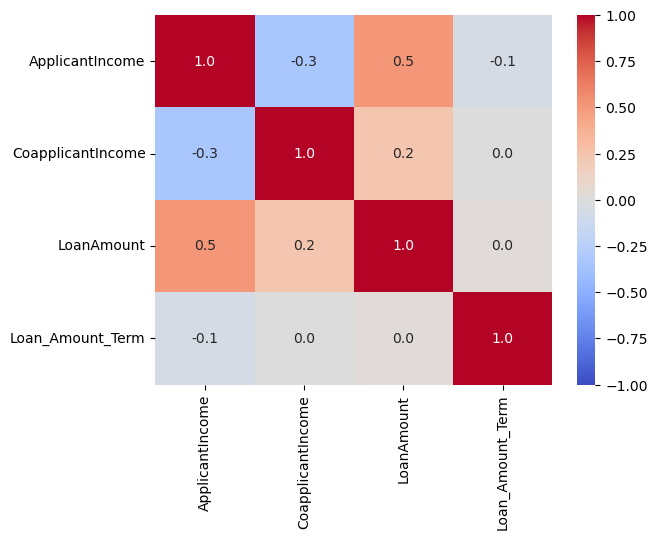

In [30]:
sns.heatmap(df_num.drop(columns=['Loan_Status']).corr(method='spearman'), cmap='coolwarm', annot=True, fmt=".1f", vmin=-1, vmax=1)
plt.show()

- Based on the plot above it shows that strong correlation only be showed between LoanAmount and Applicationincome (0.5)

## Association Analysis

In [31]:
categorical_features = df_cat.columns

In [32]:
categorical_heatmap = pd.DataFrame(
    index=categorical_features,
    columns=categorical_features,
    data=np.zeros((len(categorical_features), len(categorical_features)))
)

In [34]:
for x in categorical_heatmap.columns:
    for y in categorical_heatmap.index:
        confusion_matrix = pd.crosstab(df[x], df[y])
        chi2, _, _, _ = chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        result =  np.sqrt(phi2 / min(k - 1, r - 1))
    
        categorical_heatmap.loc[x, y] = result
        categorical_heatmap.loc[y, x] = result

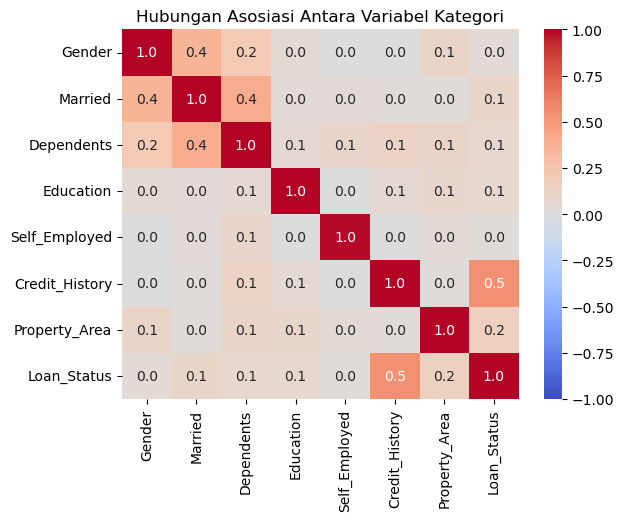

In [35]:
sns.heatmap(categorical_heatmap, cmap='coolwarm', annot=True, fmt=".1f", vmin=-1, vmax=1)
plt.title('Hubungan Asosiasi Antara Variabel Kategori')
plt.show()

Based on the plot above it shows that strong association be showed between:
- Gender - Married = 0.4
- Credit_History - Loan_Statues = 0.5.
- The rest only has weak association.

## Mixed (Correlation and Association Analysis)

In [36]:
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

def kruskal_correlation(cat, num):
    """
    Menggunakan uji Kruskal-Wallis untuk menghitung kekuatan hubungan kategori vs numerik.
    Dikonversi ke nilai korelasi pseudo dengan normalisasi.
    """
    groups = [num[cat == val] for val in np.unique(cat)]
    if len(groups) < 2:
        return np.nan
    try:
        stat, _ = kruskal(*groups)
        # Normalisasi agar berada dalam rentang [0, 1]
        n = len(num)
        return min(stat / (n + 1e-10), 1.0)
    except:
        return np.nan

def mixed_correlation(df):
    cols = df.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols)

    for col1 in cols:
        for col2 in cols:
            if df[col1].dtype == 'object' or df[col1].dtype.name == 'category':
                if df[col2].dtype == 'object' or df[col2].dtype.name == 'category':
                    conf_matrix = pd.crosstab(df[col1], df[col2])
                    corr = cramers_v(conf_matrix)
                else:
                    corr = kruskal_correlation(df[col1], df[col2])
            else:
                if df[col2].dtype == 'object' or df[col2].dtype.name == 'category':
                    corr = kruskal_correlation(df[col2], df[col1])
                else:
                    corr, _ = spearmanr(df[col1], df[col2])
            corr_matrix.loc[col1, col2] = corr

    return corr_matrix.astype(float)

In [37]:
corr = mixed_correlation(df)

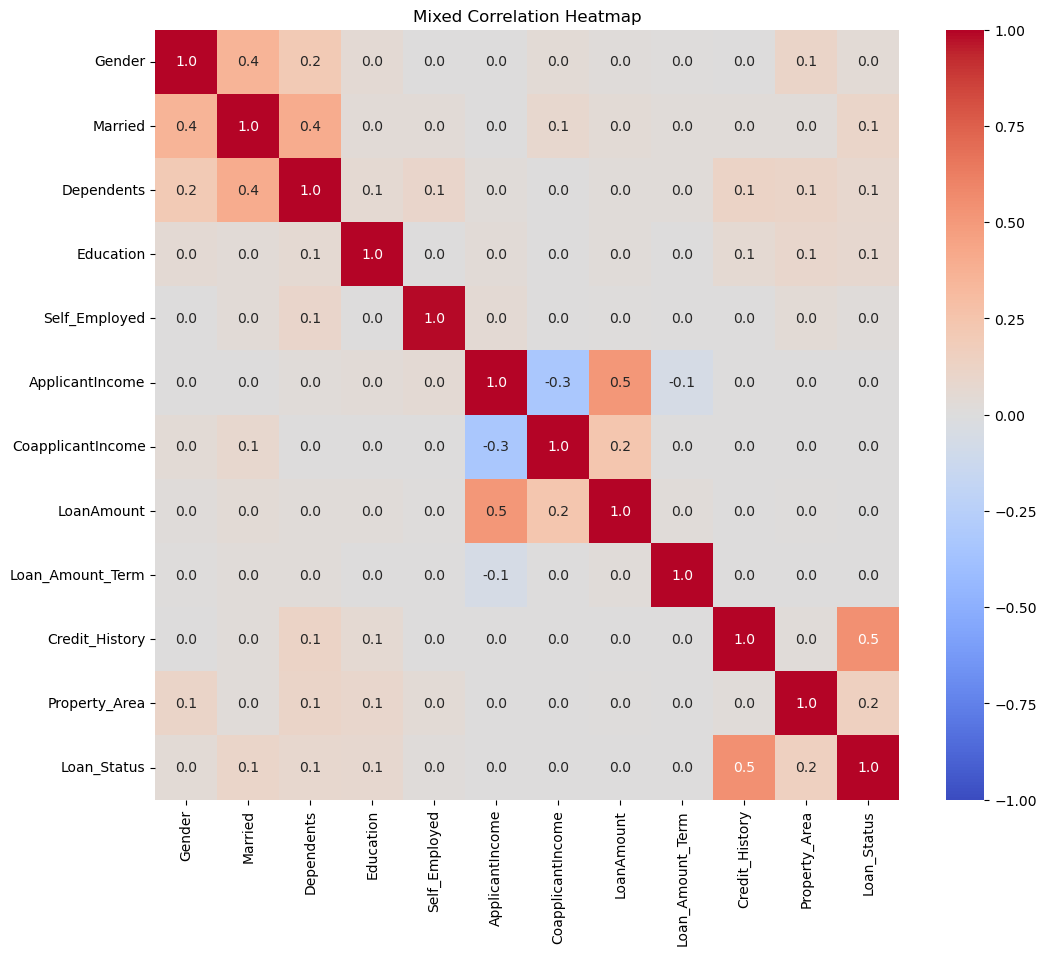

In [38]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr,  vmin=-1, vmax=1, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Mixed Correlation Heatmap')
plt.show()

- Target feature (Loan_status) only has strong relationship with credit_history (0.5) and the rest with other features only has weak relationship.

# Feature Enginnering

In [39]:
df_num = df_num.drop(columns=['Loan_Status'])

## Feature Encoding

In [40]:
df_cat = pd.get_dummies(df_cat, columns=['Gender', 'Education', 'Self_Employed', 'Credit_History', 'Loan_Status'], drop_first=True)

In [41]:
df_cat = pd.get_dummies(df_cat, columns=['Married', 'Dependents', 'Property_Area'])

In [42]:
df_cat.head()

,Gender_Male,Education_Not Graduate,Self_Employed_Yes,Credit_History_Yes,Loan_Status_Y,Married_No,Married_Yes,Married_unknown,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Dependents_unknown,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False
2,True,False,True,True,True,False,True,False,True,False,False,False,False,False,False,True
3,True,True,False,True,True,False,True,False,True,False,False,False,False,False,False,True
4,True,False,False,True,True,True,False,False,True,False,False,False,False,False,False,True
5,True,False,True,True,True,False,True,False,False,False,True,False,False,False,False,True


## Train Test Split

In [43]:
df = df_num.copy()

In [44]:
df[df_cat.columns] = df_cat

In [45]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Education_Not Graduate,Self_Employed_Yes,Credit_History_Yes,Loan_Status_Y,Married_No,Married_Yes,Married_unknown,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Dependents_unknown,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,4583,1508.0,128.0,360.0,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False
2,3000,0.0,66.0,360.0,True,False,True,True,True,False,True,False,True,False,False,False,False,False,False,True
3,2583,2358.0,120.0,360.0,True,True,False,True,True,False,True,False,True,False,False,False,False,False,False,True
4,6000,0.0,141.0,360.0,True,False,False,True,True,True,False,False,True,False,False,False,False,False,False,True
5,5417,4196.0,267.0,360.0,True,False,True,True,True,False,True,False,False,False,True,False,False,False,False,True


In [46]:
X = df.drop(columns=['Loan_Status_Y'])
y = df['Loan_Status_Y']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Feature Scalling

In [50]:
scaler = RobustScaler()

In [51]:
scaler.fit(X_train[df_num.columns])

RobustScaler()

In [52]:
X_train[df_num.columns] = scaler.transform(X_train[df_num.columns])

In [53]:
X_test[df_num.columns] = scaler.transform(X_test[df_num.columns])

## Feature Importance

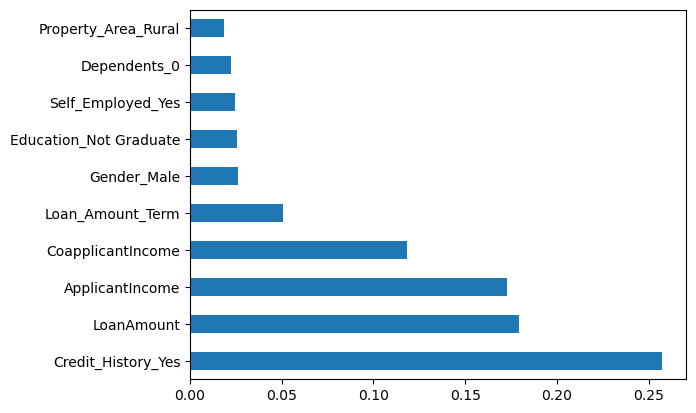

In [55]:
feature_importance = ExtraTreesClassifier()
feature_importance.fit(X_train, y_train)
feat_importances = pd.Series(feature_importance.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [56]:
X_train_sel = X_train[feat_importances.nlargest(10).index]

In [57]:
X_test_sel = X_test[feat_importances.nlargest(10).index]

# Modelling

## KNN

In [59]:
knn = KNeighborsClassifier()

In [60]:
knn.fit(X_train_sel, y_train)

KNeighborsClassifier()

In [61]:
y_pred_knn = knn.predict(X_test_sel)

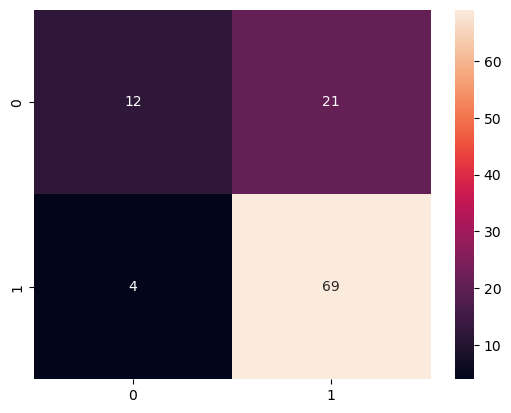

In [63]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='g')
plt.show()

In [64]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

       False       0.75      0.36      0.49        33
        True       0.77      0.95      0.85        73

    accuracy                           0.76       106
   macro avg       0.76      0.65      0.67       106
weighted avg       0.76      0.76      0.74       106



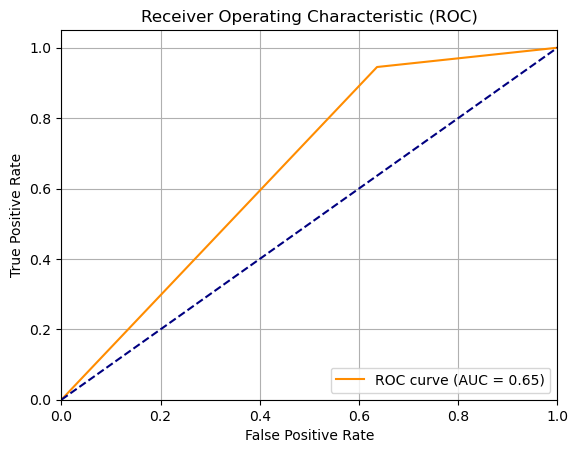

In [65]:
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_pred_knn)
auc_score_knn = roc_auc_score(y_test, y_pred_knn)
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', label=f'ROC curve (AUC = {auc_score_knn:.2f})')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## ANN

In [71]:
class MyCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90):
          print("\nReached 90% accuracy so cancelling training!")
          self.model.stop_training = True

callbacks = MyCallback()

In [72]:
ann = Sequential([
    Dense(input_shape=[10], units=20, activation='relu'),
    Dropout(0.5),
    Dense(40, activation='relu'),
    Dropout(0.5),
    Dense(80, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

C:\Users\GF63\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:
ann.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
history = ann.fit(X_train_sel, y_train, epochs=100, callbacks = ([callbacks]), validation_split=0.1, shuffle=True)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4553 - loss: 5.4214 - val_accuracy: 0.5814 - val_loss: 1.4800
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5605 - loss: 3.5339 - val_accuracy: 0.7907 - val_loss: 0.6087
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6000 - loss: 2.1273 - val_accuracy: 0.7674 - val_loss: 0.8400
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6395 - loss: 2.3342 - val_accuracy: 0.7674 - val_loss: 0.9979
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6474 - loss: 2.2589 - val_accuracy: 0.7209 - val_loss: 1.0399
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6737 - loss: 2.6283 - val_accuracy: 0.7209 - val_loss: 1.0267
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6711 - loss: 2.0675 - val_accuracy: 0.7442 - val_loss: 1.0242
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6421 - loss: 1.9318 - val_accuracy: 0.767

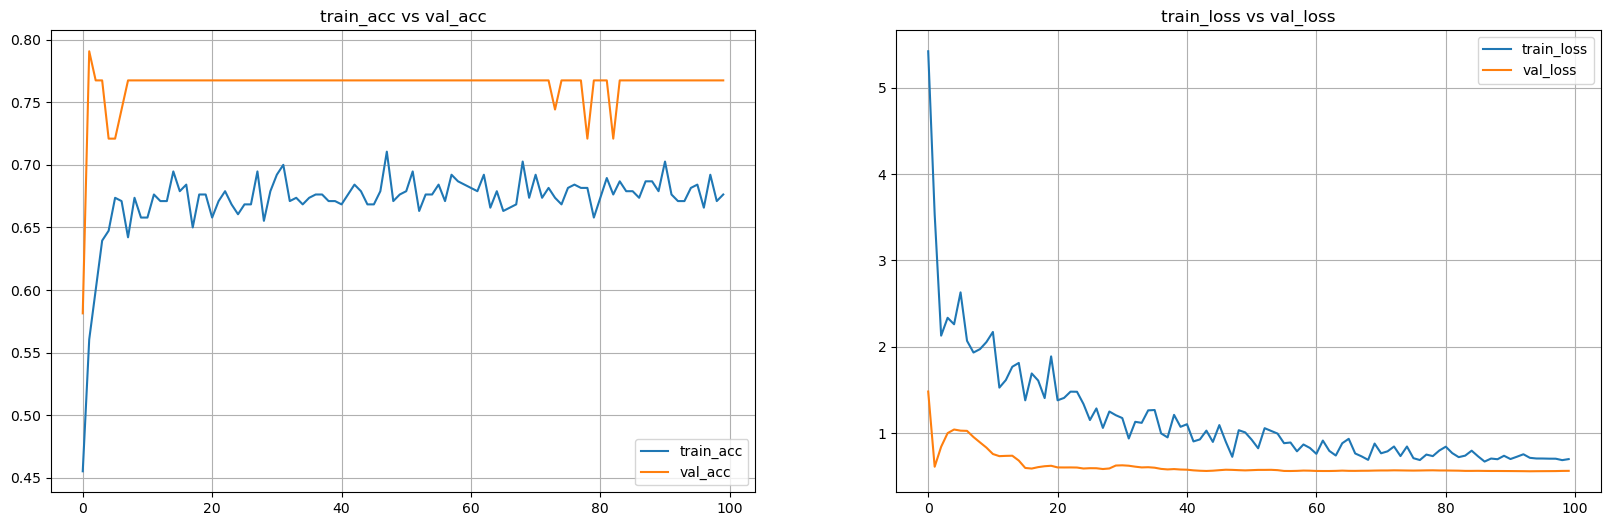

In [74]:
fig, axes = plt.subplots(1,2, figsize=[20,6])
sns.lineplot(data=history.history['accuracy'], ax=axes[0], label='train_acc')
sns.lineplot(data=history.history['val_accuracy'], ax=axes[0], label='val_acc')
axes[0].set_title('train_acc vs val_acc')


sns.lineplot(data=history.history['loss'], ax=axes[1], label='train_loss')
sns.lineplot(data=history.history['val_loss'], ax=axes[1], label='val_loss')
axes[1].set_title('train_loss vs val_loss')


axes[0].grid(True)
axes[1].grid(True)
plt.show()

In [75]:
y_pred_ann = ann.predict(X_test_sel)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [76]:
y_pred_ann = np.round(y_pred_ann)

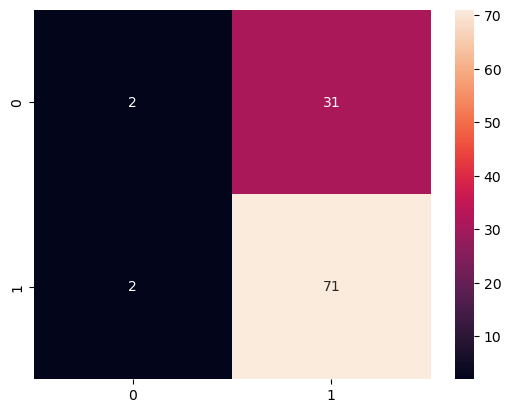

In [77]:
sns.heatmap(confusion_matrix(y_test, y_pred_ann), annot=True)
plt.show()

In [78]:
print(classification_report(y_test, y_pred_ann))

              precision    recall  f1-score   support

       False       0.50      0.06      0.11        33
        True       0.70      0.97      0.81        73

    accuracy                           0.69       106
   macro avg       0.60      0.52      0.46       106
weighted avg       0.64      0.69      0.59       106



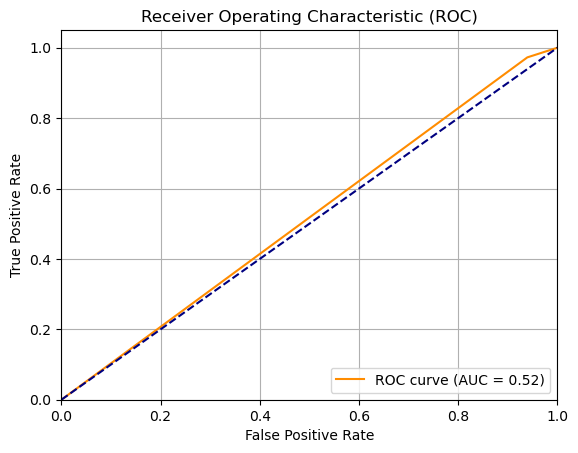

In [79]:
fpr_ann, tpr_ann, thresholds = roc_curve(y_test, y_pred_ann)
auc_score_ann = roc_auc_score(y_test, y_pred_ann)
plt.figure()
plt.plot(fpr_ann, tpr_ann, color='darkorange', label=f'ROC curve (AUC = {auc_score_ann:.2f})')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## SMOTE

In [81]:
sm = SMOTE(random_state=42)
X_train_smt, y_train_smt = sm.fit_resample(X_train_sel, y_train)

## KNN + SMOTE

In [82]:
knn_smt = KNeighborsClassifier()

In [83]:
knn_smt.fit(X_train_smt, y_train_smt)

KNeighborsClassifier()

In [84]:
y_pred_knn_smt = knn_smt.predict(X_test_sel)

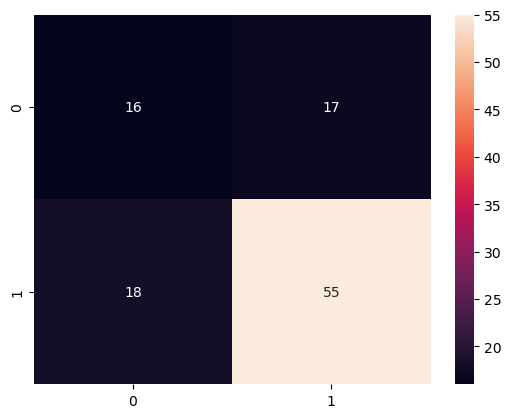

In [85]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn_smt), annot=True)
plt.show()

In [86]:
print(classification_report(y_test, y_pred_knn_smt))

              precision    recall  f1-score   support

       False       0.47      0.48      0.48        33
        True       0.76      0.75      0.76        73

    accuracy                           0.67       106
   macro avg       0.62      0.62      0.62       106
weighted avg       0.67      0.67      0.67       106



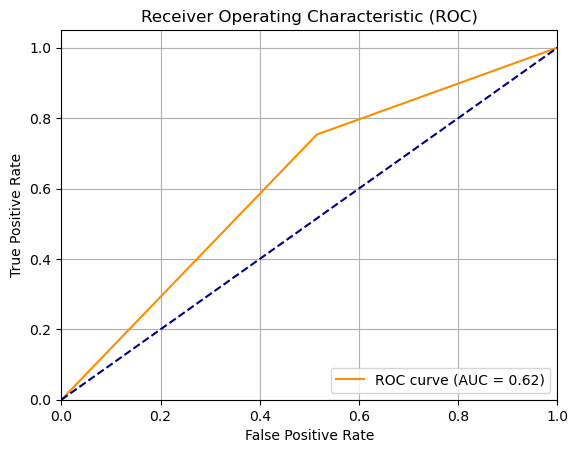

In [87]:
fpr_knn_smt, tpr_knn_smt, thresholds = roc_curve(y_test, y_pred_knn_smt)
auc_score_knn_smt = roc_auc_score(y_test, y_pred_knn_smt)
plt.figure()
plt.plot(fpr_knn_smt, tpr_knn_smt, color='darkorange', label=f'ROC curve (AUC = {auc_score_knn_smt:.2f})')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## ANN + SMOTE

In [88]:
ann_smt = Sequential([
    Dense(input_shape=[10], units=20, activation='relu'),
    Dropout(0.5),
    Dense(40, activation='relu'),
    Dropout(0.5),
    Dense(80, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

C:\Users\GF63\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [89]:
ann_smt.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
history_smt = ann_smt.fit(X_train_sel, y_train, epochs=100, callbacks = ([callbacks]), validation_split=0.1, shuffle=True)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5395 - loss: 2.6483 - val_accuracy: 0.7209 - val_loss: 0.7205
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6026 - loss: 1.7770 - val_accuracy: 0.7674 - val_loss: 0.8231
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6237 - loss: 2.9241 - val_accuracy: 0.7674 - val_loss: 0.9793
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6474 - loss: 1.5663 - val_accuracy: 0.7674 - val_loss: 1.0514
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6816 - loss: 1.7362 - val_accuracy: 0.7674 - val_loss: 1.0551
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6737 - loss: 1.9590 - val_accuracy: 0.7674 - val_loss: 0.9294
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6526 - loss: 1.8380 - val_accuracy: 0.7674 - val_loss: 0.8059
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6632 - loss: 1.7023 - val_accuracy: 0.

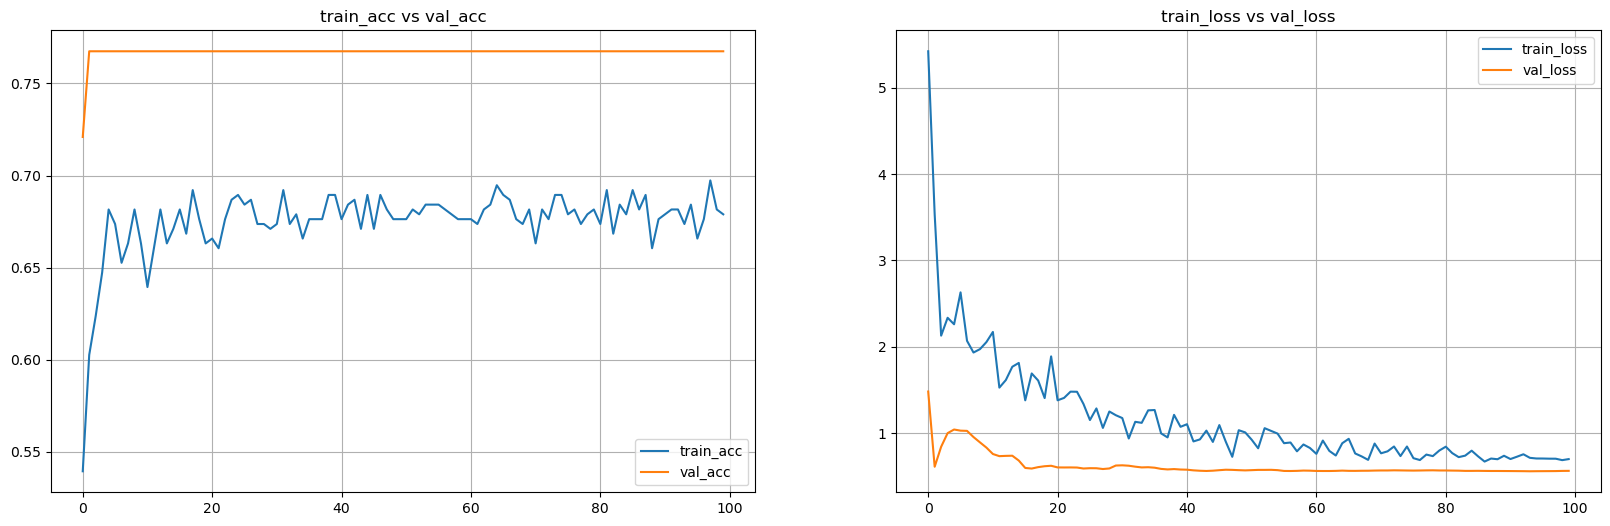

In [90]:
fig, axes = plt.subplots(1,2, figsize=[20,6])
sns.lineplot(data=history_smt.history['accuracy'], ax=axes[0], label='train_acc')
sns.lineplot(data=history_smt.history['val_accuracy'], ax=axes[0], label='val_acc')
axes[0].set_title('train_acc vs val_acc')


sns.lineplot(data=history.history['loss'], ax=axes[1], label='train_loss')
sns.lineplot(data=history.history['val_loss'], ax=axes[1], label='val_loss')
axes[1].set_title('train_loss vs val_loss')


axes[0].grid(True)
axes[1].grid(True)
plt.show()

In [91]:
y_pred_ann_smt = ann_smt.predict(X_test_sel)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [92]:
y_pred_ann_smt = np.round(y_pred_ann_smt)

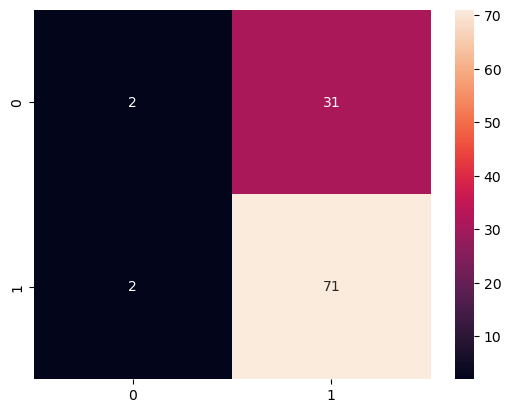

In [93]:
sns.heatmap(confusion_matrix(y_test, y_pred_ann_smt), annot=True)
plt.show()

In [94]:
print(classification_report(y_test, y_pred_ann_smt))

              precision    recall  f1-score   support

       False       0.50      0.06      0.11        33
        True       0.70      0.97      0.81        73

    accuracy                           0.69       106
   macro avg       0.60      0.52      0.46       106
weighted avg       0.64      0.69      0.59       106



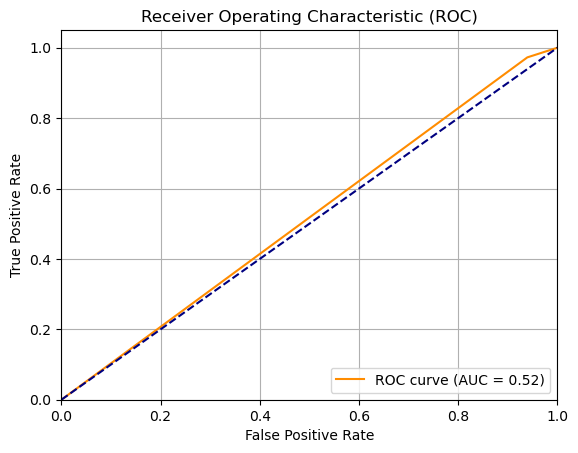

In [95]:
fpr_ann_smt, tpr_ann_smt, thresholds = roc_curve(y_test, y_pred_ann_smt)
auc_score_ann_smt = roc_auc_score(y_test, y_pred_ann_smt)
plt.figure()
plt.plot(fpr_ann_smt, tpr_ann_smt, color='darkorange', label=f'ROC curve (AUC = {auc_score_ann_smt:.2f})')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## KNN + Hyperparameter Tuning

In [96]:
knn_hyper = KNeighborsClassifier()
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_hyper,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='roc_auc',   # optimize for AUC
    n_jobs=-1            # use all cores
)
grid_search.fit(X_train_sel, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [97]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (AUC):", grid_search.best_score_)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best CV Score (AUC): 0.7367666232073011


In [98]:
y_pred_knn_hyper = grid_search.best_estimator_.predict(X_test_sel)

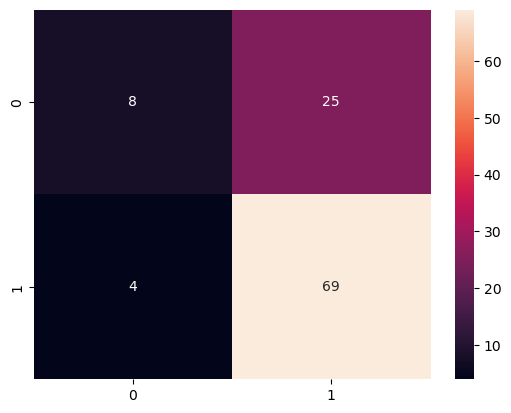

In [99]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn_hyper), annot=True)
plt.show()

In [100]:
print(classification_report(y_test, y_pred_knn_hyper))

              precision    recall  f1-score   support

       False       0.67      0.24      0.36        33
        True       0.73      0.95      0.83        73

    accuracy                           0.73       106
   macro avg       0.70      0.59      0.59       106
weighted avg       0.71      0.73      0.68       106



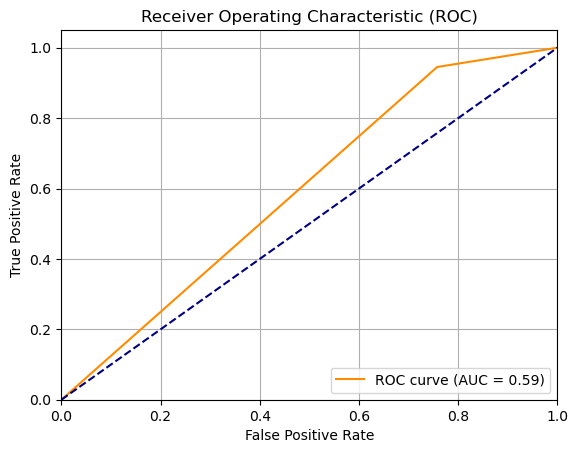

In [101]:
fpr_knn_hyper, tpr_knn_hyper, thresholds = roc_curve(y_test, y_pred_knn_hyper)
auc_score_knn_hyper = roc_auc_score(y_test, y_pred_knn_hyper)
plt.figure()
plt.plot(fpr_knn_hyper, tpr_knn_hyper, color='darkorange', label=f'ROC curve (AUC = {auc_score_knn_hyper:.2f})')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [6]:
pd.DataFrame({
    'vanilla' : [0.65, 0.52],
    'smote' : [0.62, 0.52],
    'smote + tuning': [0.59, '-'],
}, index=['KNN', 'ANN'])

,vanilla,smote,smote + tuning
KNN,0.65,0.62,0.59
ANN,0.52,0.52,-


- Because testing data is imbalance so we used roc-auc for benchmark metric to evaluate model performance.
- And after we have done several experiment such as compared model, data augmentation, and hyperparameter tuning it shows that vanilla KNN gave the best performance (ROC_AUC = 0.62).